# Spacecraft Attitude Control - PI

## Python Control System Toolbox
If you are running this code at your local computer where the python control system toolbox is already installed skip or uncomment the following line.

In [ ]:
#pip install control

## Useful Tools

We define teh following three functions that are useful for control system design:

*   `zeta = mae4182.Mp2zeta(Mp)`: convert the overshoot into the correspondin value of damping for the prototype second order system;
* `mae4182.sgrid(zeta, wn)`: draw the line of the fixed damping and the circle of the fixed natural frequency in the complex plane;
* `M_p, t_r, t_s, t_d = mae4182.step_info(sysG)`: compute the time domain specifications according to the definition of the class.

In [2]:
import control
import matplotlib.pyplot as plt
import numpy as np
import sys
import types

mae4182 = types.ModuleType('mae4182')
sys.modules['mae4182'] = mae4182

mae4182_code = '''
import control
import matplotlib.pyplot as plt
import numpy as np

import sys
import types

def Mp2zeta(Mp):
    c=np.log(Mp)**2 
    zeta = np.sqrt(c/(np.pi**2+c))                 
    return zeta


def sgrid(zeta,wn):
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    
    theta=np.linspace(0,2*np.pi,501)
    axes.plot(wn*np.cos(theta),wn*np.sin(theta),'k:')
    
    if zeta < 1:
        tan_theta=zeta/np.sqrt(1-zeta**2)
        
    if xmin < -tan_theta*ymax:
        axes.plot([0, -tan_theta*ymax],[0, ymax],'k:')
        axes.plot([0, -tan_theta*ymax],[0, ymin],'k:')
    else:
        axes.plot([0, xmin],[0, -xmin/tan_theta],'k:')
        axes.plot([0, xmin],[0, xmin/tan_theta],'k:')


def step_info(sysG):
    output = control.step_info(sysG, SettlingTimeThreshold = 0.05)
    M_p = output["Overshoot"]
    t_r = output["RiseTime"]
    t_s = output["SettlingTime"]
    output = control.step_info(sysG, RiseTimeLimits = (0,0.5))
    t_d = output["RiseTime"]
    return M_p, t_r, t_s, t_d

'''
exec(mae4182_code, mae4182.__dict__)




## Dynamics of Satellite 

Define the system tranfer function

In [3]:
import control
import matplotlib.pyplot as plt
import numpy as np

J = 1
d = 1
c = 1

sysG=control.tf(d,[J, c, 0])

display(sysG)

TransferFunction(array([1]), array([1, 1, 0]))

Since the poles are at $p_1 = 0$ and $p_2=-1$, the uncontrolled dynamcis is unstable. 


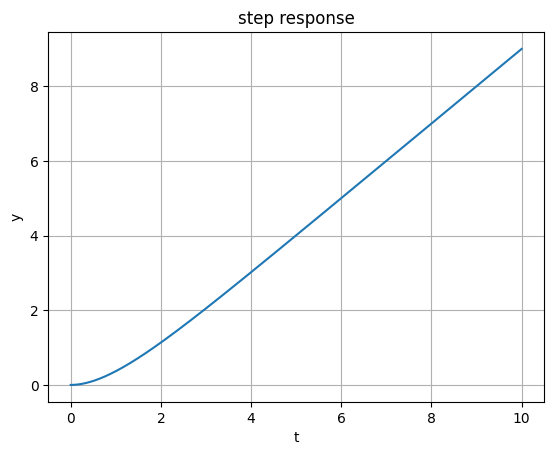

In [4]:
%matplotlib inline

N = 501
t = np.linspace(0,10,N)
t, y = control.step_response(sysG, t)
plt.plot(t,y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('step response')
plt.grid()


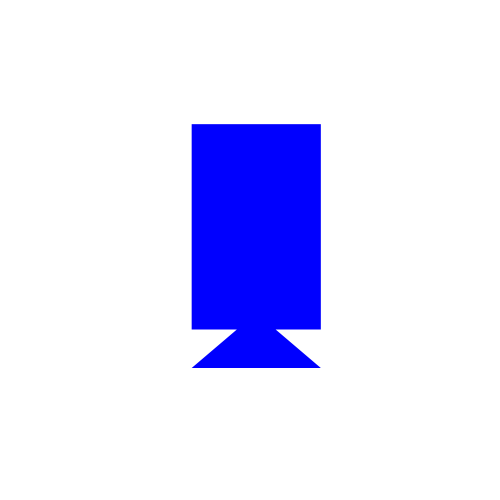

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.animation as animation
import matplotlib.patches as patches

#%matplotlib ipympl
%matplotlib widget

theta = y

# generate animation
w = 1
h = 2
b = 1.2
fw = 0.3
fb = 1.5
vertices_left = np.array([ [-w,h], [-w, -b], [-fw*w, -b], [-w, -fb*b] ]).T
vertices_right = np.array([[-1, 0], [0, 1]])@vertices_left
vertices0 = np.concatenate((vertices_left, np.fliplr(vertices_right)), axis=1)


R = np.array([[np.cos(theta[0]), np.sin(theta[0])], [-np.sin(theta[0]), np.cos(theta[0])]])
vertices = R @ vertices0

patch = Polygon(vertices.T, facecolor = 'b')

fig = plt.figure(figsize = (5,5))
ax = plt.gca()
ax.add_patch(patch)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.axis('off')
plt.show()

def init():
    return patch,

def animate(i):
    R = np.array([[np.cos(theta[i]), np.sin(theta[i])], [-np.sin(theta[i]), np.cos(theta[i])]])
    vertices = R @ vertices0

    patch.set_xy(vertices.T)
    return patch,

ani = animation.FuncAnimation(fig, animate, N, init_func=init, interval=10, repeat=False)




## Time-Domain Control Design

We wish to design a control system such that

* Steady state error due to $r=t$ is zero
* Steady state error due to $r=\frac{1}{2}t^2$  is less than 10
* Overshoot $M_p\leq 0.4$
* Settling time $t_s \leq 20$

To satisfy the first two conditions, the system type should be greater than or eqeual to 2. However, the system type of $G(s)$ is 1. Therefore, we need a PI controller to increase the system type. 

The controller transfer function is $C(s)= K + \dfrac{K_i}{s} = K(1+ \dfrac{T_i}{s})$. 
The error constant is

$$ K_a = \lim_{s\rightarrow 0} s^2 C(s)G(s) = \lim_{s\rightarrow 0} s^2 \frac{Ks+K_i }{s}\frac{1}{s(s+1)} = K_i .$$

Thus, the steady state error due to $\frac{1}{2}t^2$ is
$$ e_{ss} = \frac{1}{K_a} = \frac{1}{K_i} \leq 10. $$
Or equivalently, $K_i \geq 0.1$.
In short, the first two design specs can be satisfied by $K_i \geq 0.1$.

Next, the last two design specs are converted into the corresponding value of $(\zeta,\omega_n)$, assuming that they are simialr with the prototype second order system. 



In [7]:
Mp = 0.4
ts = 20

zeta = mae4182.Mp2zeta(Mp)
wn = 3.2/zeta/ts

print(f'zeta = {zeta:.2f}, wn={wn:.2f}')

zeta = 0.28, wn=0.57


### PI Control

The controller transfer function is $C(s)= K+ K_i s = K(1+ \dfrac{T_i}{s})$. The characteristic equation for the closed-loop system is 
$$1+C(s)G(s)= 1+ K(\dfrac{s+T_i}{s}) G(s)=0.$$ 

We first choose $T_i$, then generate a root locus with respect to $K$ as follows.

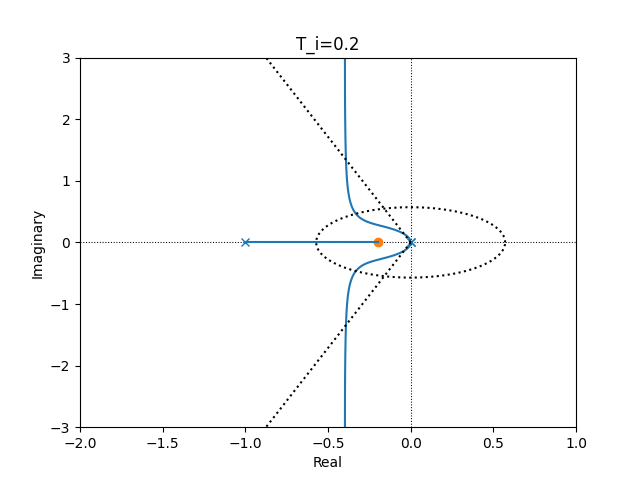

Clicked at    -0.3669   +0.7532j gain     0.8953 damp     0.4379


/Users/tylee/jax-metal/lib/python3.11/site-packages/control/rlocus.py:649: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k." (-> marker='.'). The keyword argument will take precedence.
  ax_rlocus.plot(s.real, s.imag, 'k.', marker='s', markersize=8,


In [12]:
%matplotlib widget

Ti = 0.2

sysC0 = control.tf([1, Ti],[1, 0])
plt.figure()
roots, K = control.root_locus(sysC0*sysG,xlim=[-2,1],ylim=[-3,3],grid=False)
axes = plt.gca()
axes.set_title('T_i='+str(Ti))
       

mae4182.sgrid(zeta,wn)


We simulate the step response and find the time-domain specs. 

M_p = 39.73
t_s = 6.88
K_i = 0.18


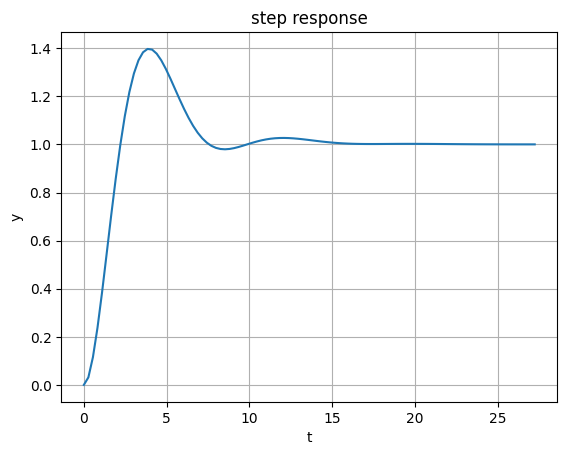

In [14]:
%matplotlib inline

K = 0.8953
Ti = 0.2
Ki = K*Ti

sysC = control.tf([K, Ki],[1, 0])
sysYR = control.feedback(sysC*sysG,1)
plt.figure()
t, y = control.step_response(sysYR)

plt.plot(t,y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('step response')
plt.grid()

M_p, t_r, t_s, t_d = mae4182.step_info(sysYR)
print(f'M_p = {M_p:.2f}')
print(f't_s = {t_s:.2f}')
print(f'K_i = {Ki:.2f}')


Next, we verify the state-state error due to a parabolic input.

e_ss = 5.58


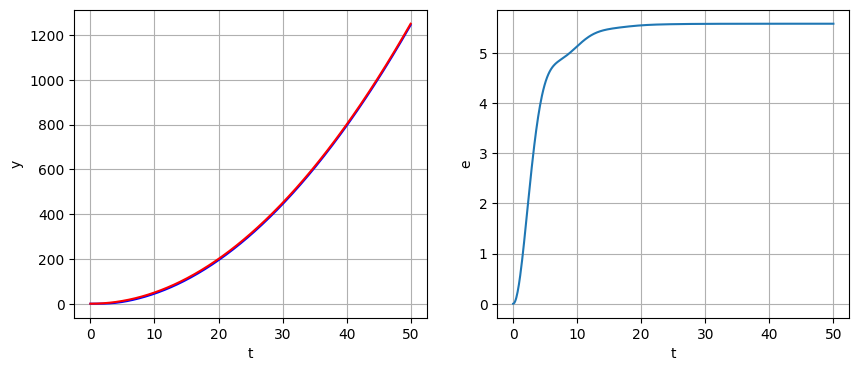

In [15]:
%matplotlib inline

t = np.linspace(0,50,501)
r = 1/2*t**2

t, y = control.forced_response(sysYR, t, r)
e = r - y
fig = plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(t,y,'b', t, r, 'r')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.subplot(1,2,2)
plt.plot(t,e)
plt.xlabel('t')
plt.ylabel('e')
plt.grid()

print(f'e_ss = {e[-1]:.2f}')

What if we wish to rotate the satellite by $90^\circ$. From the above, we have $y_{ss} = 1$ when $r=u_s(t)$. 

According to the principle of superpostiion of the linear syteme, if we choose $r=\frac{\pi}{2}u_s(t)$, then we will get $y_{ss} = \frac{\pi}{2}$. In other words, the reference input can be scaled accordingly. 

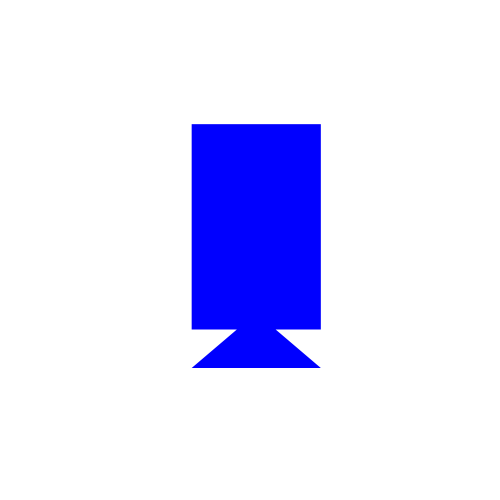

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.animation as animation
import matplotlib.patches as patches

#%matplotlib ipympl
%matplotlib widget

N = 500
t = np.linspace(0, 10, N)
t, y = control.forced_response(sysYR, t, np.pi/2)

# generate animation
w = 1
h = 2
b = 1.2
fw = 0.3
fb = 1.5
vertices_left = np.array([ [-w,h], [-w, -b], [-fw*w, -b], [-w, -fb*b] ]).T
vertices_right = np.array([[-1, 0], [0, 1]])@vertices_left
vertices0 = np.concatenate((vertices_left, np.fliplr(vertices_right)), axis=1)

#theta = np.linspace(0, 50, 100)*np.pi/180
theta = y

R = np.array([[np.cos(theta[0]), np.sin(theta[0])], [-np.sin(theta[0]), np.cos(theta[0])]])
vertices = R @ vertices0

patch = Polygon(vertices.T, facecolor = 'b')

fig = plt.figure(figsize = (5,5))
ax = plt.gca()
ax.add_patch(patch)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.axis('off')
plt.show()

def init():
    return patch,

def animate(i):
    R = np.array([[np.cos(theta[i]), np.sin(theta[i])], [-np.sin(theta[i]), np.cos(theta[i])]])
    vertices = R @ vertices0

    patch.set_xy(vertices.T)
    return patch,

ani = animation.FuncAnimation(fig, animate, N, init_func=init, interval=10, repeat=False)

